In [9]:
!pip install torch

1. Ploting Initial Condition....


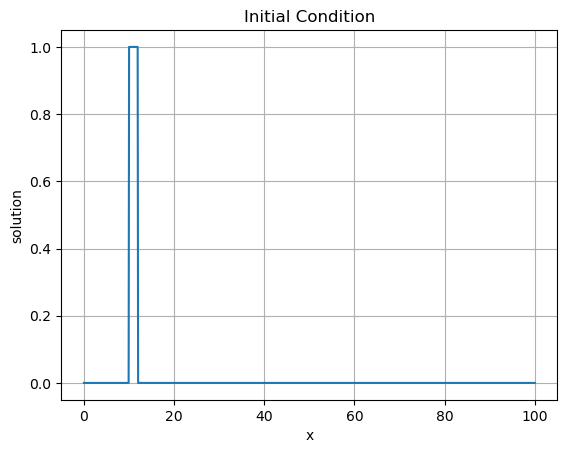


2. Generating training data....


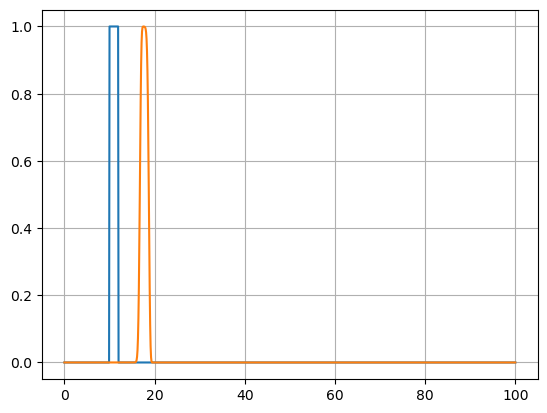

3. Train the model with Training data....
1000


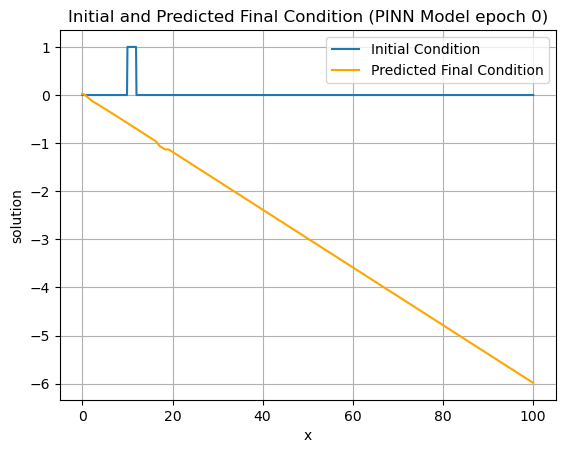

1000


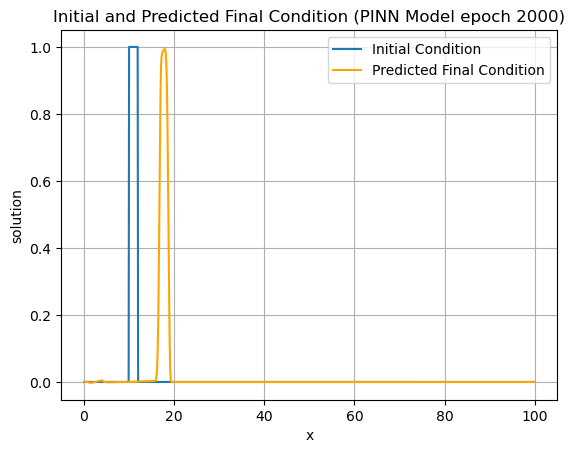

1000


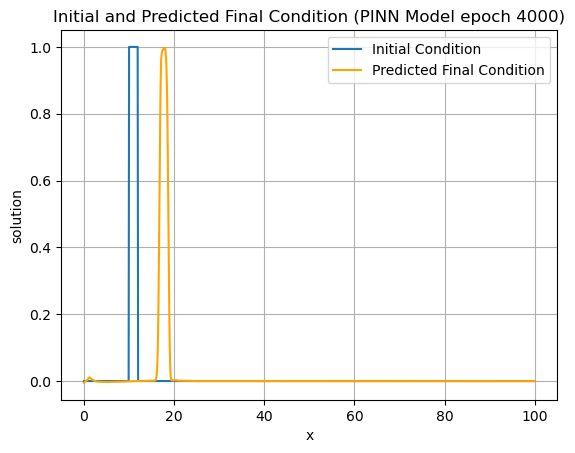

1000


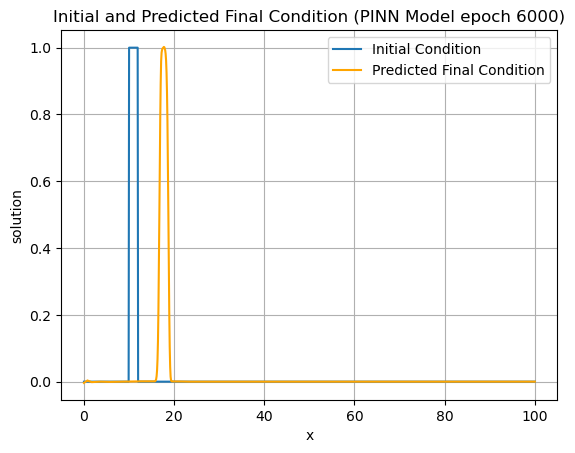

1000


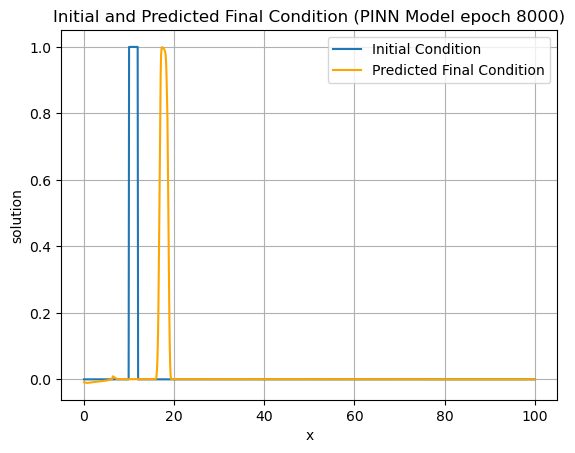

4. Plot the loss during training model....


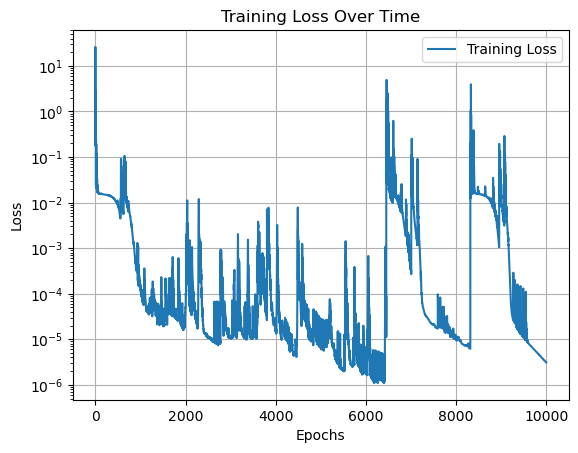

####### Training complete #########


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from torch import optim as optim
from sklearn.model_selection import train_test_split as tts

# Create initial condition
grid_points = 1000
domain = 100
grid_map = torch.linspace(0, domain, grid_points).reshape(-1, 1)
solutions = np.zeros(grid_points)
solutions[100:120] = 1


# Additional Parameters used generating training data
velocity = 1.0
time_step_size = 0.09
space_step = domain / (grid_points - 1)
num_time_steps = 75

# epochs for training data
epochs = 10000

# function to plot initial condition
def plot_initial_condition():
  plt.plot(grid_map, solutions)
  plt.grid(True)
  plt.xlabel('x')
  plt.ylabel('solution')
  plt.title('Initial Condition')
  plt.show()


In [ ]:
# function to generate training data
def generate_training_data():
    final_solution = solutions.copy()
    CFL = velocity * (time_step_size / space_step)
    for _ in range(num_time_steps):
        f_solution = final_solution.copy()
        for i in range(1, grid_points):
            final_solution[i] = f_solution[i] - CFL * (f_solution[i] - f_solution[i - 1])

    plt.plot(grid_map, solutions, label='Initial Condition')
    plt.plot(grid_map, final_solution, label = 'Target final solution')
    plt.grid(True)
    plt.show()
    return torch.tensor(final_solution, dtype=torch.float32).reshape(-1, 1)

In [ ]:
# Advection Equation used to calibrate the loss function. Used along with MSE
def adv_eqn(x, t):
    u = model(x, t)
    # Compute gradients
    dudx = torch.autograd.grad(outputs=u, inputs=x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    dudt = torch.autograd.grad(outputs=u, inputs=t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Compute advection equation
    advection_eqn = (dudt + velocity * dudx)**2
    adv_equation = advection_eqn.sum()

    return adv_equation

    # Prepare data

In [ ]:
# Define neural network model
class AdvectionPredictor(nn.Module):
    def __init__(self):
        super(AdvectionPredictor, self).__init__()
        self.layer1 = nn.Linear(2, 45)
        self.layer2 = nn.Linear(45, 45)
        self.layer3 = nn.Linear(45, 45)  # Added another layer
        self.layer4 = nn.Linear(45, 1)

    def forward(self, x, t):
      #print(self.layer1(x))
      x = torch.cat((x, t), dim=1)
      x = torch.relu(self.layer1(x))
      x = torch.relu(self.layer2(x))
      x = torch.relu(self.layer3(x))
      x = self.layer4(x)
      return x

#1. Plot the Initial Condition
print('1. Ploting Initial Condition....')
plot_initial_condition()
print('')
#2. Generate Training Data
print('2. Generating training data....')
y_train = generate_training_data().requires_grad_(True)
x_train = grid_map.requires_grad_(True)

# y_train, y_test, x_train, x_test = tts(y_train, x_train, test_size=0.2, random_state=42)

#3. Initialize model, loss, and optimizer
model = AdvectionPredictor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss = []

In [ ]:
# Train the model
def train_model():
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x_train, y_train)
        adv_loss = adv_eqn(y_train, x_train)
        loss = criterion(outputs, y_train)
        total_loss = loss+adv_loss
        total_loss.backward()
        optimizer.step()
        train_loss.append(total_loss.item())

        if epoch%2000 == 0:
          with torch.no_grad():
            model.eval()
            y_prediction = model(x_train, y_train)
            print(len(y_prediction))
            plt.figure()
            plt.plot(grid_map, solutions, label='Initial Condition')
            plt.plot(grid_map, y_prediction, label='Predicted Final Condition', linestyle='-', color='orange')
            plt.grid(True)
            plt.xlabel('x')
            plt.ylabel('solution')
            plt.title(f'Initial and Predicted Final Condition (PINN Model epoch {epoch})')
            plt.legend()
            plt.show()
    test_loss = []
    # for epoch in range(epochs):
    #   with torch.no_grad():
    #     y_test = model(x_test, y_test)
    #     loss = criterion(x_test, y_test)
    #     adv_loss = adv_eqn(y_test, x_test)
    #     t_loss = loss+adv_loss
    #     t_loss.backward()
    #     optimizer.step()
    #     test_loss.append(t_loss.item())




    return train_loss


In [ ]:
# Plot the loss over time
def plot_train_loss():
  plt.figure()
  plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
  plt.grid(True)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.yscale("log")
  plt.title('Training Loss Over Time')
  plt.legend()
  plt.show()

# Train the model
print('3. Train the model with Training data....')
train_loss = train_model()

# Plot the Loss
print('4. Plot the loss during training model....')
plot_train_loss()


print(f'####### Training complete #########')
